# Genetic algorithm search for perovskites for water splitting

In this part of the project we will use a genetic algorithm (GA) to predict the best perovskite oxide for two photon water splitting.

## Background

You should have followed the previous exercise on predicting perovskites for water splitting for a one photon device using the cubic_perovskites.db database. This project should feel like a natural extension, now we just allow `O3` as the anion and change the evaluation to fit with the two photon picture as shown below.

![split-water](images/two-photons.png)

Start by downloading the database if you haven't already done so.

In [8]:
!wget https://cmr.fysik.dtu.dk/_downloads/cubic_perovskites.db

--2018-11-08 21:24:36--  https://cmr.fysik.dtu.dk/_downloads/cubic_perovskites.db
Resolving cmr.fysik.dtu.dk... 130.225.86.24, 2001:878:200:2010:3::24
Connecting to cmr.fysik.dtu.dk|130.225.86.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47226880 (45M) [text/plain]
Saving to: `cubic_perovskites.db.1'

100%[======================================>] 47,226,880   111M/s   in 0.4s    

2018-11-08 21:24:36 (111 MB/s) - `cubic_perovskites.db.1' saved [47226880/47226880]



## Start the GA



In [34]:
# Connect the database
from ase.db import connect
db = connect('cubic_perovskites.db')

# Create a list with possible AB_ions and anions they should both be lists
A_ions, B_ions, anions = set(), set(), set()
for dct in db.select('anion=O3'):
    A_ions.add(dct.A_ion)
    B_ions.add(dct.B_ion)
    anions.add(dct.anion)

AB_ions = list(A_ions)
anions = list(anions)
print(len(AB_ions))
print(len(anions))
print(AB_ions)
print(anions)
print(len(AB_ions)*len(AB_ions)*len(anions))

52
1
['Ni', 'Ta', 'Ge', 'K', 'Mg', 'Hg', 'Cd', 'Mn', 'As', 'Si', 'Cr', 'Pb', 'Li', 'Mo', 'Na', 'Re', 'Sn', 'Au', 'Be', 'Y', 'W', 'Ir', 'Ga', 'Tl', 'Ca', 'Rh', 'Bi', 'Sc', 'Cu', 'Sb', 'Pd', 'Al', 'Rb', 'Te', 'Pt', 'Sr', 'Co', 'In', 'Zn', 'Ag', 'Ba', 'Nb', 'Cs', 'Hf', 'Ru', 'Ti', 'La', 'Zr', 'V', 'Os', 'B', 'Fe']
['O3']
2704


We will start by putting the reference database into local memory. This makes lookup of values of each candidate much faster. Then we will set up another database that will hold the candidates generated by the GA.

In [35]:
from ase.db import connect

def build_ref_dict(ref_db):
    dct = {}
    for row in ref_db.select('anion=O3'):
        # Use a key: A-B-X to look up each row
        s = '-'.join([row.A_ion, row.B_ion, row.anion])
        dct[s] = row
    return dct

# The reference database are put in local memory for faster lookup
db = connect('cubic_perovskites.db')
ref_dict = build_ref_dict(db)
print('built ref dictionary')

built ref dictionary


The variables below are needed to initialize the GA

In [36]:
# File name
ga_db_file = 'ga_two_photon_water_splitters.db'

# Define the population size
pop_size = 50

Here we initialize the database file that holds information about the GA run.

In [37]:
from ase.ga.data import PrepareDB

# Initialize the GA database
prep_ga_db = PrepareDB(ga_db_file,
                       population_size=pop_size,
                       anions=anions, AB_ions=AB_ions)

Now we create the initial population by creating random candidates.

In [38]:
import random

# Construct a random starting population
print('Generating random population of size {0}'.format(pop_size))
start_set = set()
for _ in range(pop_size):
    # Choose two random from AB_ions and one random from anions
    cand = random.sample(AB_ions, 2) + random.sample(anions, 1)
    s = '-'.join(cand)
    # We don't want duplicates in the starting population
    if s in start_set:
        continue
    start_set.add(s)
    # A candidate is added to the database, it is not evaluated (unrelaxed)
    prep_ga_db.add_unrelaxed_candidate(ref_dict[s].toatoms(),
                                       atoms_string=s)
print('Done.')

Generating random population of size 50
Done.


Run the cell below if *and only if* you need to restart the algorithm. It will delete all the progress in the database file.

In [33]:
import os
if os.path.isfile(ga_db_file):
    os.remove(ga_db_file)

## Run the GA

First we need to use a different class for the database.

In [39]:
from ase.ga.data import DataConnection

ga_db = DataConnection(ga_db_file)

Then we will evaluate the starting population. For the two-photon device each candidate is evaluated based on stability (heat of formation), band gap and maximum of valence band (positioned correct compared to the O2/H2O potential). *Note*: You need to input the minimum band gap for the two photon device.

The evaluation of each candidate ends with an assigment of a raw score. The raw score help to determine how fit each candidate is when comparing to the rest of the population. For more information see the function `get_raw_score` in the file ga_help.py

In [40]:
from ga_help import evaluate_two_photons, get_evaluated_set

minimum_band_gap = 1.7

# Evaluate the starting population
candidates_to_be_added = []
for a in ga_db.get_all_unrelaxed_candidates():
    evaluate_two_photons(a, ref_dict, minimum_band_gap)
    candidates_to_be_added.append(a)
ga_db.add_more_relaxed_candidates(candidates_to_be_added)

# Keep track of the candidates that has been evaluated
already_evaluated = get_evaluated_set(ga_db_file)

The algorithm works by maintaining a population of candidates, that is evolved towards the optimal candidates as the algorithm run progresses. Below we initialize the population class.

In [41]:
from ase.ga.standard_comparators import StringComparator
from ase.ga.population import Population
# Define how to compare two different candidates
comp = StringComparator('atoms_string')

# The population is kept in the Population instance
pop = Population(data_connection=ga_db,
                 population_size=pop_size,
                 comparator=comp)

![perovskite](images/perovskite.png)

Each candidate is represented by a list of elements `[A, B, X]`. The algorithm will evolve the population not unlike natural evolution by combining and mutating the best candidates in the population to create new candidates better adjusted to fit the environment.




In [42]:
from ase.ga.offspring_creator import OperationSelector
from list_operators import OnePointListCrossover, RandomListMutation,\
    NeighborhoodListMutation, ListPermutation, RandomListCreation

# Specify the procreation operators for the algorithm and the probability for using each
# RandomListMutation and NeighborhoodListMutation should not get the
# anions list since there is only one possible anion

probability_list = [1, 3, 1, 1, 1]

oclist = (probability_list, [RandomListMutation([AB_ions]),
                             OnePointListCrossover(),
                             NeighborhoodListMutation([AB_ions]),
                             RandomListCreation([AB_ions, anions], [2, 1]),
                             ListPermutation([AB_ions, anions])])
operation_selector = OperationSelector(*oclist)

Now we write the loop that in essence is the algorithm. Try and run the cell below a couple of times and see that fitter candidates are produced as the population evolves.

In [51]:
from ga_help import set_syms, get_atoms_string

print('Number of evaluated candidates in database: {0}'.format(len(already_evaluated)))
worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
# Get the largest gaid in db
max_id = ga_db.get_largest_in_db('gaid')

# This many candidates will be tested in this loop
num_cands = 500

# Run the algorithm
add_later = []
for i in range(1, num_cands + 1):
    offspring = None
    while offspring is None or s in already_evaluated:
        # Select parents
        a1, a2 = pop.get_two_candidates(with_history=False)
        
        # Select procreation operator
        op = operation_selector.get_operator()
        
        # Do the operation
        offspring = op.get_new_individual([a1, a2])
        
        # Get the candidate as a string to check if it has already
        # been evaluated
        s = get_atoms_string(offspring)

    # Technical details not important
    a3, desc = offspring
    set_syms(a3, ref_dict[s])
    already_evaluated.add(s)
    # We don't save the unrelaxed candidates in this case, due to speed
    # So we have to set an artificial confid
    # db.add_unrelaxed_candidate(a3, description=desc)
    a3.info['confid'] = i + max_id

    # Invoke the evaluation
    evaluate_two_photons(a3, ref_dict, minimum_band_gap)

    # If the evaluated candidate will enter the population it will be saved
    # now, else it is written after the loop terminates
    if a3.info['key_value_pairs']['raw_score'] > worst_raw_score_in_pop:
        ga_db.add_relaxed_step(a3)

        pop.update()
        worst_raw_score_in_pop = pop.pop[-1].info['key_value_pairs']['raw_score']
    else:
        add_later.append(a3)

    # Print the progress of the algorithm for every 200 evaluated candidates
    if i % 200 == 0:
        print('Best 20 in the population after {0} evaluations'.format(i))
        for j in range(20):
            cand = pop.pop[j].info['key_value_pairs']
            print(f'Candidate #{j + 1} in the population:', cand['atoms_string'],
                  cand['raw_score'])

        worst = pop.pop[-1].info['key_value_pairs']
        print('Worst candidate in population:', worst['atoms_string'],
              worst['raw_score'])
        print(50 * '-')

print('Writing rest of candidates to database (#{0})'.format(len(add_later)))
ga_db.add_more_relaxed_candidates(add_later)

Number of evaluated candidates in database: 1050
Best 20 in the population after 200 evaluations
Candidate #1 in the population: Na-V-O3 150.0
Candidate #2 in the population: Ga-Ta-O3 150.0
Candidate #3 in the population: Tl-Ta-O3 150.0
Candidate #4 in the population: Sr-Ge-O3 141.2646800376373
Candidate #5 in the population: Ca-Ge-O3 141.2646800376373
Candidate #6 in the population: Ba-Sn-O3 140.48374180359593
Candidate #7 in the population: Sn-Ti-O3 140.48374180359593
Candidate #8 in the population: Li-V-O3 138.46745195799537
Candidate #9 in the population: Cd-Ti-O3 130.4037353098209
Candidate #10 in the population: Cu-Nb-O3 125.2905317116908
Candidate #11 in the population: Au-Ta-O3 125.2905317116908
Candidate #12 in the population: Cu-Ta-O3 124.5979016321057
Candidate #13 in the population: Pb-Ge-O3 122.80961296169728
Candidate #14 in the population: Sn-Sn-O3 120.37781969437178
Candidate #15 in the population: Na-Sb-O3 119.32369296996974
Candidate #16 in the population: Tl-Nb-O3 11

In [48]:
from ga_help import get_raw_score
from ase.db import connect
from operator import itemgetter

def generate_top_list(fname):
    ref_db = connect('cubic_perovskites.db')
    all_list = []
    for row in ref_db.select('anion=O3'):
        s = '-'.join([row.A_ion, row.B_ion, row.anion])
        all_list.append((s, get_raw_score(row, method='product')))

    fd = open(fname, 'w')
    # sort the list by the raw score
    all_list.sort(key=itemgetter(1), reverse=True)
    for st, rs in all_list:
        print(st, rs, file=fd)
    fd.close()

generate_top_list('top_list.txt')

In [49]:
# Print out the top 20 candidates and their raw score
!head -20 top_list.txt

Sr-Sn-O3 200.0
Ba-Sn-O3 200.0
Sn-Ti-O3 200.0
Na-V-O3 199.53135739731692
Ga-Ta-O3 198.08459850688277
Ca-Sn-O3 188.35290671684973
Sr-Ge-O3 188.35290671684973
Ca-Ge-O3 188.35290671684973
Li-V-O3 184.62326927732715
Cs-Nb-O3 184.62326927732715
In-Nb-O3 182.81988896045328
Ag-Nb-O3 180.9674836071919
Na-Sb-O3 180.9674836071919
Cu-Ta-O3 177.3840873434315
Ga-Nb-O3 177.02793788213316
K-Sb-O3 176.6664197450204
Tl-Ta-O3 173.86467444585492
Zn-Ti-O3 170.42875779324226
Tl-Nb-O3 167.1712486315351
Rb-Nb-O3 167.0320046035639


In [52]:
# Get the top list from the text file top_list.txt
f = open('top_list.txt')
top_list = []
for l in f:
    top_list.append(l.split(' ')[0])
f.close()

# Only consider the top 20
top_number = 20
top_list = top_list[:top_number]
    
db = connect(ga_db_file)
found = set()
i = 0
for row in db.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        print(f'# found candidates in top {top_number}: {lf}. {s} evaluated as number: {i}')

# found candidates in top 20: 1. Sr-Sn-O3 evaluated as number: 91
# found candidates in top 20: 2. Sr-Ge-O3 evaluated as number: 103
# found candidates in top 20: 3. Ca-Ge-O3 evaluated as number: 107
# found candidates in top 20: 4. Ca-Sn-O3 evaluated as number: 123
# found candidates in top 20: 5. Ga-Nb-O3 evaluated as number: 136
# found candidates in top 20: 6. Ba-Sn-O3 evaluated as number: 189
# found candidates in top 20: 7. Zn-Ti-O3 evaluated as number: 224
# found candidates in top 20: 8. Na-V-O3 evaluated as number: 238
# found candidates in top 20: 9. Sn-Ti-O3 evaluated as number: 303
# found candidates in top 20: 10. Ga-Ta-O3 evaluated as number: 309
# found candidates in top 20: 11. Tl-Ta-O3 evaluated as number: 441
# found candidates in top 20: 12. Li-V-O3 evaluated as number: 449
# found candidates in top 20: 13. Na-Sb-O3 evaluated as number: 636
# found candidates in top 20: 14. Tl-Nb-O3 evaluated as number: 747
# found candidates in top 20: 15. In-Nb-O3 evaluated as numb

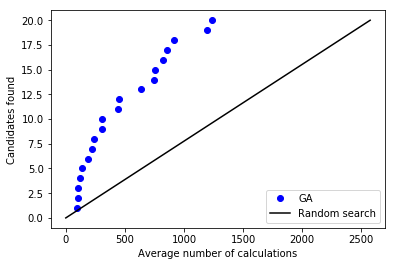

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from plot_help import remove_duplicate_labels

def random_search(number_of_candidates):
    search_space = 2704
    return (number_of_candidates * (search_space + 1)) / (top_number + 1)


# Plot the number of found candidates by GA as a function of evaluated candidates
found = set()
i = 0
for row in db.select('relaxed=1', sort='gaid'):
    i += 1
    s = row.atoms_string
    if s in top_list and s not in found:
        found.add(s)
        lf = len(found)
        plt.plot(i, lf, 'bo', label='GA')
        
# Plot the random search
y = np.array(range(top_number + 1))
plt.plot(random_search(y), y, 'k-', label='Random search')
plt.xlabel('Average number of calculations')
plt.ylabel('Candidates found')
remove_duplicate_labels(plt.gca())
plt.savefig('GA.png')
plt.show()